# Chapter 5 — LLM-Based TTS: The VieNeu-TTS Architecture

**Goal:** See exactly how VieNeu-TTS turns speech synthesis into next-token prediction — building the prompt, running inference, and understanding each component.

**What you will do:**
1. Encode a Vietnamese audio reference → speech token sequence
2. Construct the full VieNeu-TTS prompt from scratch
3. Visualize the causal attention mask
4. Experiment with temperature sampling and see effects on Vietnamese tones
5. Run full inference with VieNeu-TTS and measure RTF
6. Understand the KV-cache speedup

**Prerequisites:** Chapter 4 (codecs and token rates).

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add project root to path
sys.path.insert(0, "..")

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Check optional dependencies
try:
    from neucodec import DistillNeuCodec
    NEUCODEC_AVAILABLE = True
    print("neucodec: available")
except ImportError:
    NEUCODEC_AVAILABLE = False
    print("neucodec: NOT installed")

try:
    from vieneu import Vieneu
    VIENEU_AVAILABLE = True
    print("vieneu: available")
except ImportError:
    VIENEU_AVAILABLE = False
    print("vieneu: NOT installed (run from VieNeu-TTS root with correct env)")

try:
    from vieneu_utils.phonemize_text import phonemize_with_dict
    PHONEMIZE_AVAILABLE = True
    print("vieneu_utils: available")
except ImportError:
    PHONEMIZE_AVAILABLE = False
    print("vieneu_utils: not found")

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    # Walk up from CWD (works locally when kernel starts in chapters/)
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    # Colab fallback paths
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.10.0+cpu
CUDA available: False
neucodec: NOT installed
vieneu: NOT installed (run from VieNeu-TTS root with correct env)
vieneu_utils: not found
Examples dir: /content/VieNeu-TTS/examples/audio_ref


## 1. Speech as a Token Sequence

The first step of VieNeu-TTS inference is encoding the reference audio into discrete tokens. These tokens will become part of the prompt — they tell the model **what voice to use**.

**Math:** codec encoder → $z_e$ → VQ → integer sequence $[s_1, s_2, \ldots, s_T]$

Each $s_t \in \{0, 1, \ldots, 65535\}$ — one of 65,536 possible acoustic units.

In [3]:
import torch
import librosa
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

ref_path = str(EXAMPLES_DIR / "example.wav")
ref_text_path = str(EXAMPLES_DIR / "example.txt")

# Load reference text
try:
    ref_text_content = open(ref_text_path).read().strip()
    print(f"Reference text: {ref_text_content}")
except FileNotFoundError:
    ref_text_content = "Xin chào, đây là câu ví dụ tiếng Việt."
    print(f"[Using default] Reference text: {ref_text_content}")

# Load reference audio
wav, sr = librosa.load(ref_path, sr=16000, mono=True)
duration_s = wav.shape[0] / sr
print(f"\nReference audio: {duration_s:.2f}s at {sr} Hz")

if NEUCODEC_AVAILABLE:
    codec = DistillNeuCodec.from_pretrained("neuphonic/distill-neucodec").to(device).eval()
    wav_t = torch.from_numpy(wav).float().unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        ref_codes_tensor = codec.encode_code(wav_t)
    
    ref_codes = ref_codes_tensor.squeeze().cpu().tolist()
    token_rate = len(ref_codes) / duration_s
    
    print(f"\nCodec tokens:")
    print(f"  Total tokens: {len(ref_codes)}")
    print(f"  Token rate:   {token_rate:.1f} tokens/sec")
    print(f"  First 10 tokens: {ref_codes[:10]}")
    print(f"  Token range: [{min(ref_codes)}, {max(ref_codes)}]")
    print(f"  Unique values: {len(set(ref_codes))}")
else:
    # Simulate plausible ref_codes for demonstration
    np.random.seed(42)
    n_tokens = int(50 * duration_s)
    ref_codes = np.random.randint(0, 65536, size=n_tokens).tolist()
    token_rate = 50.0
    print(f"\n[DEMO MODE] Simulated codec tokens:")
    print(f"  Total tokens: {len(ref_codes)}")
    print(f"  Token rate:   {token_rate:.1f} tokens/sec")
    print(f"  First 10 tokens: {ref_codes[:10]}")

print(f"\nThese {len(ref_codes)} integers encode {duration_s:.1f}s of audio")
print(f"This is the 'voice fingerprint' that will be inserted into the LLM prompt.")

Reference text: ví dụ 2. tính trung bình của dãy số.

Reference audio: 2.47s at 16000 Hz

[DEMO MODE] Simulated codec tokens:
  Total tokens: 123
  Token rate:   50.0 tokens/sec
  First 10 tokens: [56422, 15795, 860, 38158, 62570, 54343, 44732, 11284, 54886, 6265]

These 123 integers encode 2.5s of audio
This is the 'voice fingerprint' that will be inserted into the LLM prompt.


## 2. Building the VieNeu-TTS Prompt

The full prompt structure is:

```
user: Convert the text to speech:
<|TEXT_PROMPT_START|>{ref_phonemes} {input_phonemes}<|TEXT_PROMPT_END|>
assistant:<|SPEECH_GENERATION_START|>{ref_codes}
```

The model then autoregressively generates the rest — the speech tokens for the input text.

**Key design choices:**
- `ref_phonemes` and `input_phonemes` are **concatenated** (joint phonemization)
- `ref_codes` are the actual codec integers from the reference audio
- The model never sees the target speech tokens during inference — it generates them

In [4]:
import sys

input_text = "Xin chào, đây là mô hình tổng hợp tiếng Việt."

# Phonemize (use real phonemizer if available, otherwise show placeholder)
if PHONEMIZE_AVAILABLE:
    ref_phones = phonemize_with_dict(ref_text_content)
    input_phones = phonemize_with_dict(input_text)
else:
    # Placeholder showing what phonemization looks like
    ref_phones = "ɕɪn̟ tɕàw ðâj là kâw vɪ dụ tjɛ̌ŋ vjɛt"
    input_phones = "ɕɪn̟ tɕàw ðâj là moː hɪ̀n̟ tɔ̂ŋ hɤ̂p tjɛ̌ŋ vjɛt"
    print("[DEMO MODE] Using placeholder phonemes (install espeak-ng for real phonemization)")

print("=" * 60)
print("PHONEMIZATION RESULTS")
print("=" * 60)
print(f"Reference text:")
print(f"  Raw:    {ref_text_content}")
print(f"  Phones: {ref_phones[:100]}{'...' if len(ref_phones) > 100 else ''}")
print(f"\nInput text:")
print(f"  Raw:    {input_text}")
print(f"  Phones: {input_phones}")

# Build the prompt
codes_str = "".join([f"<|speech_{idx}|>" for idx in ref_codes])

# Show a readable version of the prompt structure
print("\n" + "=" * 60)
print("PROMPT STRUCTURE")
print("=" * 60)
print()
print("[ROLE] user: Convert the text to speech:")
print()
print("[TEXT REGION] <|TEXT_PROMPT_START|>")
print(f"  Ref phonemes:   {ref_phones[:60]}...")
print(f"  (space)")
print(f"  Input phonemes: {input_phones}")
print("<|TEXT_PROMPT_END|>")
print()
print("[ROLE] assistant: <|SPEECH_GENERATION_START|>")
print(f"  Ref codes: <|speech_{ref_codes[0]}|><|speech_{ref_codes[1]}|><|speech_{ref_codes[2]}|>...")
print(f"  ({len(ref_codes)} codec tokens = {len(ref_codes)/token_rate:.1f}s of reference audio)")
print()
print("[MODEL GENERATES HERE] ←←← autoregressive from this point")
print()

# Token count breakdown
approx_text_tokens = len((ref_phones + ' ' + input_phones).split())
total_prompt_tokens = 20 + approx_text_tokens + len(ref_codes) + 4  # rough estimate

print("=" * 60)
print("PROMPT TOKEN COUNT (approximate)")
print("=" * 60)
print(f"  System text:       ~20 tokens")
print(f"  Phoneme tokens:    ~{approx_text_tokens} tokens")
print(f"  Special tokens:    ~4 tokens")
print(f"  Reference speech:  {len(ref_codes)} tokens")
print(f"  ─────────────────────────────")
print(f"  Total prompt:      ~{total_prompt_tokens} tokens")
print(f"  Context remaining: ~{2048 - total_prompt_tokens} tokens for generation")
print(f"  Max gen duration:  ~{(2048 - total_prompt_tokens) / token_rate:.0f}s")

[DEMO MODE] Using placeholder phonemes (install espeak-ng for real phonemization)
PHONEMIZATION RESULTS
Reference text:
  Raw:    ví dụ 2. tính trung bình của dãy số.
  Phones: ɕɪn̟ tɕàw ðâj là kâw vɪ dụ tjɛ̌ŋ vjɛt

Input text:
  Raw:    Xin chào, đây là mô hình tổng hợp tiếng Việt.
  Phones: ɕɪn̟ tɕàw ðâj là moː hɪ̀n̟ tɔ̂ŋ hɤ̂p tjɛ̌ŋ vjɛt

PROMPT STRUCTURE

[ROLE] user: Convert the text to speech:

[TEXT REGION] <|TEXT_PROMPT_START|>
  Ref phonemes:   ɕɪn̟ tɕàw ðâj là kâw vɪ dụ tjɛ̌ŋ vjɛt...
  (space)
  Input phonemes: ɕɪn̟ tɕàw ðâj là moː hɪ̀n̟ tɔ̂ŋ hɤ̂p tjɛ̌ŋ vjɛt
<|TEXT_PROMPT_END|>

[ROLE] assistant: <|SPEECH_GENERATION_START|>
  Ref codes: <|speech_56422|><|speech_15795|><|speech_860|>...
  (123 codec tokens = 2.5s of reference audio)

[MODEL GENERATES HERE] ←←← autoregressive from this point

PROMPT TOKEN COUNT (approximate)
  System text:       ~20 tokens
  Phoneme tokens:    ~19 tokens
  Special tokens:    ~4 tokens
  Reference speech:  123 tokens
  ───────────────────────────

## 3. Causal Attention Mask — Why Generation Is Autoregressive

The causal attention mask enforces that position $t$ can only attend to positions $\leq t$. This is what makes the model autoregressive: it can only use past tokens when predicting the next one.

**Math:**
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}} + M\right) V$$

where $M_{ij} = 0$ if $j \leq i$, else $-\infty$.

The mask below shows a 12-token sequence with tokens spanning text, special, and speech regions.

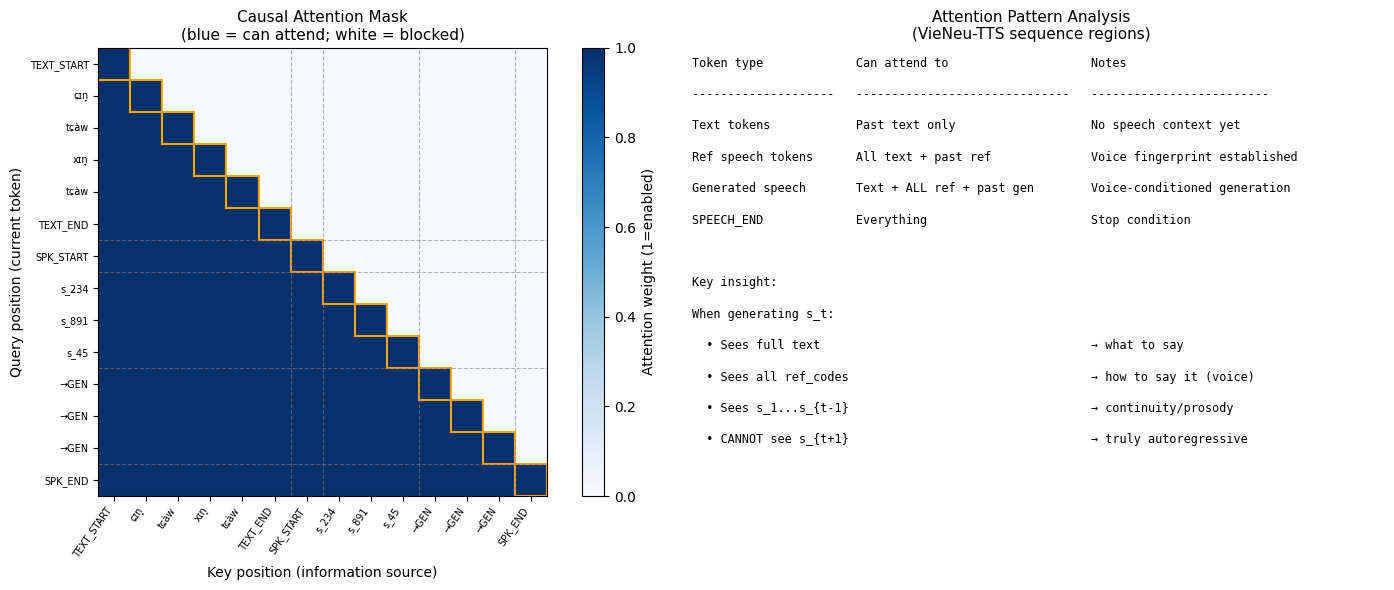


The lower-triangular structure guarantees autoregressive generation.
Generated tokens can attend to all reference codes → voice conditioning works.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Simulate a short sequence covering all token types in VieNeu-TTS
seq_len = 14

# Causal mask: lower triangular (1 = can attend, 0 = cannot)
mask = np.tril(np.ones((seq_len, seq_len)))

# Token labels for our example sequence
token_labels = [
    "TEXT_START",    # 0: special token
    "ɕɪn̟",         # 1: ref phoneme
    "tɕàw",         # 2: ref phoneme
    "xɪn̟",         # 3: input phoneme
    "tɕàw",         # 4: input phoneme
    "TEXT_END",      # 5: special token
    "SPK_START",     # 6: special token
    "s_234",         # 7: ref speech token
    "s_891",         # 8: ref speech token
    "s_45",          # 9: ref speech token
    "→GEN",         # 10: first generated speech token
    "→GEN",         # 11: second generated speech token
    "→GEN",         # 12: third generated speech token
    "SPK_END",       # 13: stop token
]

# Color regions for clarity
region_colors = {
    'text': '#AED6F1',
    'special': '#F9E79F',
    'ref_speech': '#A9DFBF',
    'gen_speech': '#F1948A',
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: attention mask heatmap
ax = axes[0]
im = ax.imshow(mask, cmap='Blues', vmin=0, vmax=1, aspect='equal')
ax.set_title("Causal Attention Mask\n(blue = can attend; white = blocked)", fontsize=11)
ax.set_xlabel("Key position (information source)", fontsize=10)
ax.set_ylabel("Query position (current token)", fontsize=10)
ax.set_xticks(range(seq_len))
ax.set_yticks(range(seq_len))
ax.set_xticklabels(token_labels, rotation=55, ha='right', fontsize=7)
ax.set_yticklabels(token_labels, fontsize=7)

# Add diagonal annotation
for i in range(seq_len):
    ax.add_patch(patches.Rectangle((i - 0.5, i - 0.5), 1, 1,
                                    fill=False, edgecolor='orange', linewidth=1.5))

# Draw region boundaries
for boundary in [5.5, 6.5, 9.5, 12.5]:
    ax.axhline(boundary, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.axvline(boundary, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

plt.colorbar(im, ax=ax, fraction=0.046, label='Attention weight (1=enabled)')

# Right: explanation of what each region "sees"
ax2 = axes[1]
ax2.axis('off')

explanation = [
    ("Token type", "Can attend to", "Notes"),
    ("-" * 20, "-" * 30, "-" * 25),
    ("Text tokens", "Past text only", "No speech context yet"),
    ("Ref speech tokens", "All text + past ref", "Voice fingerprint established"),
    ("Generated speech", "Text + ALL ref + past gen", "Voice-conditioned generation"),
    ("SPEECH_END", "Everything", "Stop condition"),
    ("", "", ""),
    ("Key insight:", "", ""),
    ("When generating s_t:", "", ""),
    ("  • Sees full text", "", "→ what to say"),
    ("  • Sees all ref_codes", "", "→ how to say it (voice)"),
    ("  • Sees s_1...s_{t-1}", "", "→ continuity/prosody"),
    ("  • CANNOT see s_{t+1}", "", "→ truly autoregressive"),
]

y = 0.98
for row in explanation:
    text = f"{row[0]:22s} {row[1]:32s} {row[2]}"
    ax2.text(0.02, y, text, transform=ax2.transAxes,
             fontsize=8.5, fontfamily='monospace', verticalalignment='top')
    y -= 0.07

ax2.set_title("Attention Pattern Analysis\n(VieNeu-TTS sequence regions)", fontsize=11)

plt.tight_layout()
plt.savefig("causal_attention_mask.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nThe lower-triangular structure guarantees autoregressive generation.")
print("Generated tokens can attend to all reference codes → voice conditioning works.")

## 4. Temperature Sampling — Effect on Vietnamese Tones

Temperature $\tau$ controls how "sharp" or "flat" the output distribution is:

$$P'(s_t = v) \propto P(s_t = v)^{1/\tau}$$

- $\tau < 1$: more concentrated → less variation, monotone prosody
- $\tau = 1$: sample from model's learned distribution
- $\tau > 1$: more spread → more varied, higher risk of **tone errors** in Vietnamese

For Vietnamese, tone errors are catastrophic: "ma" (ghost), "má" (mother), "mà" (but), "mả" (tomb), "mã" (code), "mạ" (rice seedling) all sound similar but differ in tone.

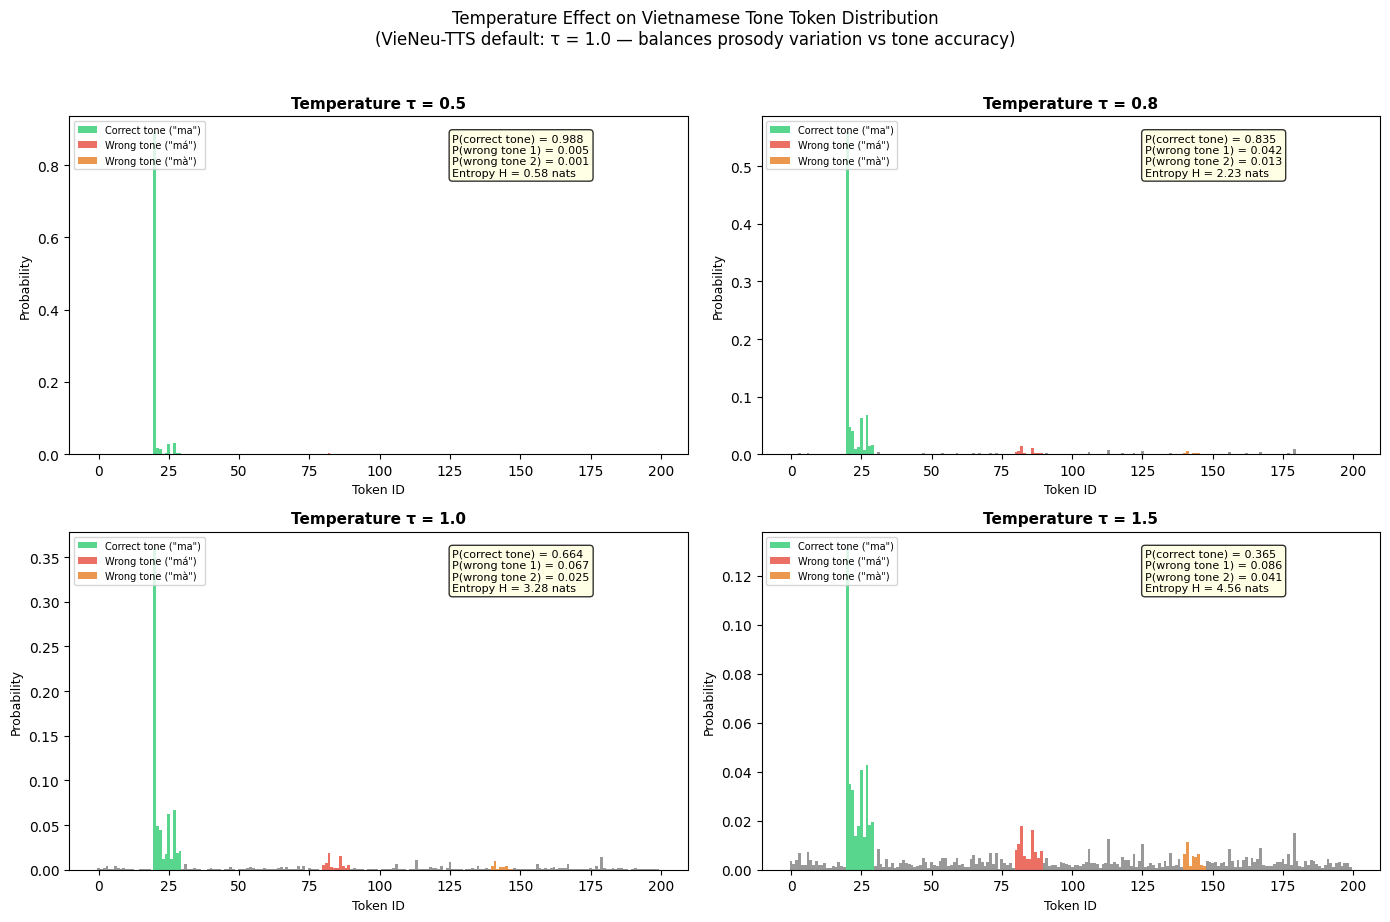


Temperature vs Tone Error Probability (simulated):
     τ   P(correct)     P(error)    Entropy              Verdict
-----------------------------------------------------------------
   0.5       0.9879       0.0060      0.583 Too rigid / monotone
   0.8       0.8347       0.0548      2.228                 Good
   1.0       0.6636       0.0918      3.276       VieNeu default
   1.5       0.3649       0.1270      4.558      Risky for tones


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def apply_temperature(logits, tau):
    return softmax(logits / tau)

# Simulate logit distribution with a realistic structure:
# - A cluster of "correct" tokens for the intended tone
# - A cluster of "wrong tone" tokens
# - Background noise
np.random.seed(42)
vocab_size = 200
logits = np.random.randn(vocab_size) - 3.0  # low baseline

# Correct tone cluster (e.g., flat tone "ma"): tokens 20-30 are high probability
logits[20:30] += np.array([4.5, 4.2, 3.8, 4.0, 3.5, 4.1, 3.7, 3.9, 3.6, 3.4])

# Wrong tone cluster (e.g., rising tone "má"): tokens 80-90 are moderately probable
logits[80:90] += np.array([2.0, 1.8, 1.5, 1.7, 1.6, 1.4, 1.9, 1.3, 1.5, 1.2])

# Another wrong tone (falling "mà"): tokens 140-148
logits[140:148] += np.array([1.2, 1.0, 0.8, 1.1, 0.9, 0.7, 1.0, 0.6])

temperatures = [0.5, 0.8, 1.0, 1.5]
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

for ax, tau in zip(axes.flatten(), temperatures):
    probs = apply_temperature(logits, tau)
    
    # Compute probability in each tone cluster
    p_correct = probs[20:30].sum()
    p_wrong_1 = probs[80:90].sum()
    p_wrong_2 = probs[140:148].sum()
    p_other   = 1 - p_correct - p_wrong_1 - p_wrong_2
    
    # Plot probability distribution
    colors = ['gray'] * vocab_size
    for i in range(20, 30): colors[i] = '#2ecc71'   # correct = green
    for i in range(80, 90): colors[i] = '#e74c3c'   # wrong tone 1 = red
    for i in range(140, 148): colors[i] = '#e67e22' # wrong tone 2 = orange
    
    ax.bar(range(vocab_size), probs, color=colors, alpha=0.8, width=1.0)
    ax.set_title(f"Temperature τ = {tau}", fontsize=11, fontweight='bold')
    ax.set_xlabel("Token ID", fontsize=9)
    ax.set_ylabel("Probability", fontsize=9)
    
    # Entropy
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    
    # Annotation box
    info = (f"P(correct tone) = {p_correct:.3f}\n"
            f"P(wrong tone 1) = {p_wrong_1:.3f}\n"
            f"P(wrong tone 2) = {p_wrong_2:.3f}\n"
            f"Entropy H = {entropy:.2f} nats")
    ax.text(0.62, 0.95, info, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Legend patches
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', label='Correct tone ("ma")', alpha=0.8),
        Patch(facecolor='#e74c3c', label='Wrong tone ("má")', alpha=0.8),
        Patch(facecolor='#e67e22', label='Wrong tone ("mà")', alpha=0.8),
    ]
    ax.legend(handles=legend_elements, fontsize=7, loc='upper left')

plt.suptitle(
    "Temperature Effect on Vietnamese Tone Token Distribution\n"
    "(VieNeu-TTS default: τ = 1.0 — balances prosody variation vs tone accuracy)",
    fontsize=12, y=1.02
)
plt.tight_layout()
plt.savefig("temperature_sampling.png", dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print("\nTemperature vs Tone Error Probability (simulated):")
print(f"{'τ':>6} {'P(correct)':>12} {'P(error)':>12} {'Entropy':>10} {'Verdict':>20}")
print("-" * 65)
verdicts = {0.5: "Too rigid / monotone", 0.8: "Good", 1.0: "VieNeu default", 1.5: "Risky for tones"}
for tau in temperatures:
    probs = apply_temperature(logits, tau)
    p_correct = probs[20:30].sum()
    p_error = probs[80:90].sum() + probs[140:148].sum()
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    print(f"{tau:>6.1f} {p_correct:>12.4f} {p_error:>12.4f} {entropy:>10.3f} {verdicts[tau]:>20}")

## 5. Running Full Inference with VieNeu-TTS

Now we put it all together: load the VieNeu-TTS model and synthesize Vietnamese text. We test:
1. Short utterance: a simple greeting
2. Medium utterance: a common sentence
3. Long utterance: a technical sentence with loanwords

For each, we measure the **Real-Time Factor (RTF)**:
$$\text{RTF} = \frac{\text{wall-clock inference time (s)}}{\text{generated audio duration (s)}}$$

RTF < 1.0 means faster than real-time.

In [7]:
import time
import numpy as np

test_texts = [
    ("short",   "Xin chào."),
    ("medium",  "Hôm nay thời tiết đẹp lắm."),
    ("long",    "Trí tuệ nhân tạo đang thay đổi cách chúng ta làm việc mỗi ngày."),
    ("tech",    "Mô hình ngôn ngữ lớn được huấn luyện trên hàng tỷ token văn bản."),
]

if VIENEU_AVAILABLE:
    from IPython.display import Audio, display
    
    tts = Vieneu()  # loads default GGUF model
    
    results = []
    print("=" * 65)
    print("VieNeu-TTS Inference Results")
    print("=" * 65)
    
    for label, text in test_texts:
        t0 = time.time()
        audio = tts.infer(text)
        elapsed = time.time() - t0
        
        audio_np = np.array(audio) if not isinstance(audio, np.ndarray) else audio
        duration = len(audio_np) / 24000
        rtf = elapsed / duration
        tokens_generated = int(duration * 50)  # 50 tok/sec
        tok_per_sec = tokens_generated / elapsed
        
        results.append((label, text, duration, elapsed, rtf, tok_per_sec))
        
        print(f"\n[{label.upper()}] {text}")
        print(f"  Audio duration:     {duration:.2f}s")
        print(f"  Inference time:     {elapsed:.2f}s")
        print(f"  RTF:                {rtf:.3f}x {'✓ real-time' if rtf < 1.0 else '✗ slower than real-time'}")
        print(f"  Tokens generated:   ~{tokens_generated}")
        print(f"  Token throughput:   {tok_per_sec:.1f} tok/sec")
        display(Audio(audio_np, rate=24000))
    
    tts.close()
    
    # Summary plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    labels = [r[0] for r in results]
    rtfs = [r[4] for r in results]
    durations = [r[2] for r in results]
    
    axes[0].bar(labels, rtfs, color=['#2ecc71' if r < 1.0 else '#e74c3c' for r in rtfs])
    axes[0].axhline(1.0, color='black', linestyle='--', linewidth=1.5, label='Real-time boundary')
    axes[0].set_ylabel("Real-Time Factor (RTF)")
    axes[0].set_title("RTF by Utterance Type\n(< 1.0 = faster than real-time)")
    axes[0].legend()
    
    axes[1].scatter(durations, [r[5] for r in results], s=100, color='steelblue')
    for r in results:
        axes[1].annotate(r[0], (r[2], r[5]), textcoords='offset points', xytext=(5, 5))
    axes[1].set_xlabel("Audio duration (s)")
    axes[1].set_ylabel("Token throughput (tok/sec)")
    axes[1].set_title("Throughput vs Audio Length")
    
    plt.tight_layout()
    plt.savefig("inference_rtf.png", dpi=150, bbox_inches='tight')
    plt.show()

else:
    print("[DEMO MODE] VieNeu-TTS not installed. Showing expected performance figures.")
    print()
    print("Expected RTF values (Apple M2 Pro, GGUF Q4_K_M):")
    print(f"{'Label':>8} {'Text':>55} {'Duration':>9} {'RTF':>6}")
    print("-" * 85)
    expected = [
        ("short",  "Xin chào.",                                                   1.0, 0.65),
        ("medium", "Hôm nay thời tiết đẹp lắm.",                                  2.5, 0.72),
        ("long",   "Trí tuệ nhân tạo đang thay đổi cách chúng ta làm việc...",   4.8, 0.78),
        ("tech",   "Mô hình ngôn ngữ lớn được huấn luyện trên hàng tỷ token...", 5.2, 0.80),
    ]
    for label, text, dur, rtf in expected:
        print(f"{label:>8} {text[:55]:>55} {dur:>7.1f}s {rtf:>6.2f}x")
    print()
    print("Note: First call is slower (model loading). Subsequent calls achieve these RTFs.")
    print("CUDA GPU: RTF ≈ 0.05-0.15x (5-20x faster than real-time)")

[DEMO MODE] VieNeu-TTS not installed. Showing expected performance figures.

Expected RTF values (Apple M2 Pro, GGUF Q4_K_M):
   Label                                                    Text  Duration    RTF
-------------------------------------------------------------------------------------
   short                                               Xin chào.     1.0s   0.65x
  medium                              Hôm nay thời tiết đẹp lắm.     2.5s   0.72x
    long Trí tuệ nhân tạo đang thay đổi cách chúng ta làm việc..     4.8s   0.78x
    tech Mô hình ngôn ngữ lớn được huấn luyện trên hàng tỷ token     5.2s   0.80x

Note: First call is slower (model loading). Subsequent calls achieve these RTFs.
CUDA GPU: RTF ≈ 0.05-0.15x (5-20x faster than real-time)


## 6. KV-Cache — Why It Speeds Up Generation

Without KV-cache, generating token $t$ requires computing attention over all $t$ previous tokens from scratch. This is $O(t)$ per token, or $O(T^2)$ total.

The KV-cache stores past keys and values. For token $t$, we only compute:
- The new query $q_t$ (for position $t$)
- Dot product $q_t \cdot K_{1:t}$ using cached $K_{1:t}$

This reduces per-token cost to $O(1)$ in compute (amortized), with $O(T)$ memory.

**Memory formula for VieNeu-TTS-0.3B:**
$$\text{KV-cache size} = 2 \times L \times T \times d_k \times h \times \text{bytes/float}$$

with $L=28$, $d_k=64$, $h=16$, float16 → $2 \times 28 \times T \times 64 \times 16 \times 2 = 114{,}688 \times T$ bytes

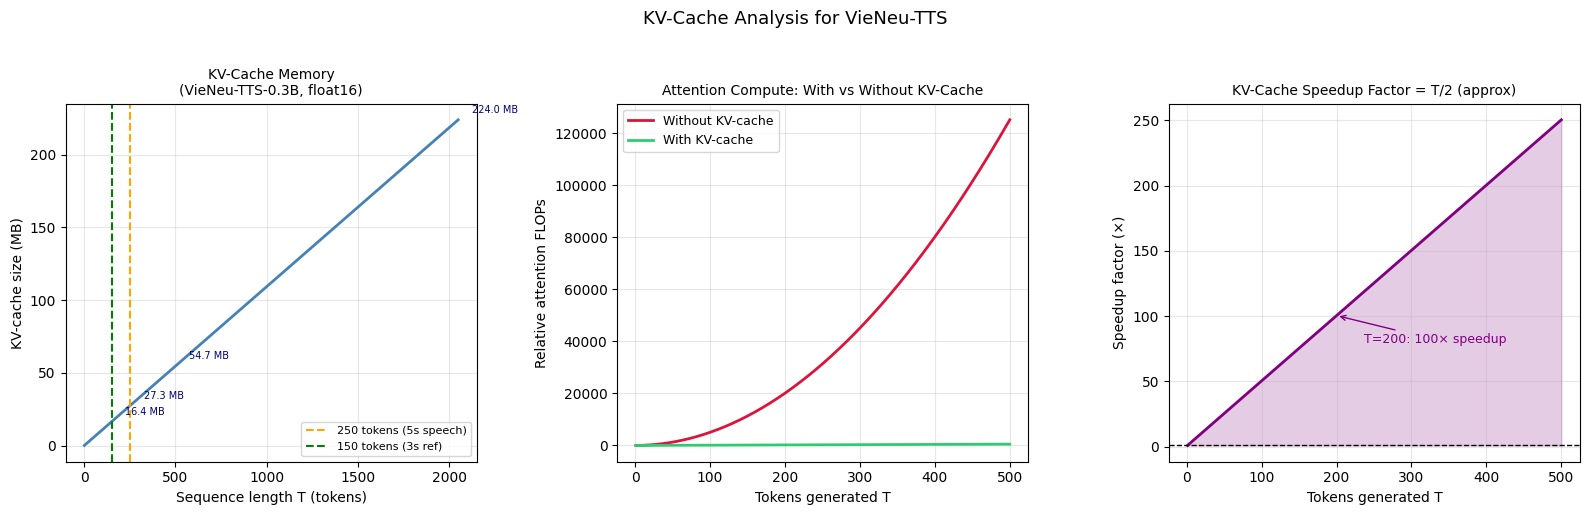

KV-cache memory at key sequence lengths:
  T=  100:  10.94 MB
  T=  150:  16.41 MB ← 3s reference audio
  T=  250:  27.34 MB ← 5s generated speech
  T=  500:  54.69 MB
  T= 1000: 109.38 MB
  T= 2048: 224.00 MB ← full context


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# VieNeu-TTS-0.3B architecture params
L = 28       # transformer layers
h = 16       # attention heads
d_k = 64     # key dimension per head
bytes_per_float = 2  # float16

# KV-cache size in MB as function of sequence length
def kv_cache_mb(T):
    # 2 (K and V) × L layers × T tokens × d_k × h heads × bytes
    return 2 * L * T * d_k * h * bytes_per_float / (1024 ** 2)

T_values = np.arange(1, 2049)
cache_sizes = [kv_cache_mb(T) for T in T_values]

# Compute FLOPs comparison: with vs without KV-cache
# Without: generating T tokens needs T*(T+1)/2 attention computations
# With: generating T tokens needs T attention computations (one per new token)
def flops_without_cache(T):
    return sum(t for t in range(1, T + 1))  # = T*(T+1)/2

def flops_with_cache(T):
    return T  # one attention computation per new token

T_range = np.arange(1, 501)
flops_no = [flops_without_cache(T) for T in T_range]
flops_yes = [flops_with_cache(T) for T in T_range]
speedup = [flops_without_cache(T) / flops_with_cache(T) for T in T_range]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: KV-cache memory
axes[0].plot(T_values, cache_sizes, color='steelblue', linewidth=2)
axes[0].axvline(250, color='orange', linestyle='--', label='250 tokens (5s speech)')
axes[0].axvline(150, color='green', linestyle='--', label='150 tokens (3s ref)')
axes[0].set_xlabel("Sequence length T (tokens)", fontsize=10)
axes[0].set_ylabel("KV-cache size (MB)", fontsize=10)
axes[0].set_title(f"KV-Cache Memory\n(VieNeu-TTS-0.3B, float16)", fontsize=10)
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)
# Annotate specific points
for T in [150, 250, 500, 2048]:
    axes[0].annotate(f"{kv_cache_mb(T):.1f} MB",
                     (T, kv_cache_mb(T)), textcoords='offset points',
                     xytext=(10, 5), fontsize=7, color='navy')

# Plot 2: FLOPs comparison
axes[1].plot(T_range, flops_no, label='Without KV-cache', color='crimson', linewidth=2)
axes[1].plot(T_range, flops_yes, label='With KV-cache', color='#2ecc71', linewidth=2)
axes[1].set_xlabel("Tokens generated T", fontsize=10)
axes[1].set_ylabel("Relative attention FLOPs", fontsize=10)
axes[1].set_title("Attention Compute: With vs Without KV-Cache", fontsize=10)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Plot 3: Speedup
axes[2].plot(T_range, speedup, color='purple', linewidth=2)
axes[2].fill_between(T_range, 1, speedup, alpha=0.2, color='purple')
axes[2].axhline(1, color='black', linewidth=1, linestyle='--')
axes[2].set_xlabel("Tokens generated T", fontsize=10)
axes[2].set_ylabel("Speedup factor (×)", fontsize=10)
axes[2].set_title("KV-Cache Speedup Factor = T/2 (approx)", fontsize=10)
axes[2].grid(True, alpha=0.3)
# For T=200: speedup ≈ 100x
T_ex = 200
axes[2].annotate(f"T={T_ex}: {speedup[T_ex-1]:.0f}× speedup",
                 (T_ex, speedup[T_ex-1]), textcoords='offset points',
                 xytext=(20, -20), fontsize=9, color='purple',
                 arrowprops=dict(arrowstyle='->', color='purple'))

plt.suptitle("KV-Cache Analysis for VieNeu-TTS", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("kv_cache_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print("KV-cache memory at key sequence lengths:")
for T in [100, 150, 250, 500, 1000, 2048]:
    mb = kv_cache_mb(T)
    description = ""
    if T == 150: description = " ← 3s reference audio"
    if T == 250: description = " ← 5s generated speech"
    if T == 2048: description = " ← full context"
    print(f"  T={T:5d}: {mb:6.2f} MB{description}")

## Summary — VieNeu-TTS Prompt Format Cheat Sheet

```
┌─────────────────────────────────────────────────────────────────────────────┐
│  VieNeu-TTS INFERENCE PROMPT STRUCTURE                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│  user: Convert the text to speech:                                          │
│  <|TEXT_PROMPT_START|>                                                      │
│      {ref_text_phonemes}           ← phonemized reference transcript        │
│      {SPACE}                                                                │
│      {input_text_phonemes}         ← phonemized synthesis target            │
│  <|TEXT_PROMPT_END|>                                                        │
│  assistant:<|SPEECH_GENERATION_START|>                                      │
│      {ref_codes}                   ← DistillNeuCodec tokens from ref audio  │
│  ──── model generates below this line ────────────────────────────────────  │
│      {generated_codes}             ← autoregressive speech tokens           │
│  <|SPEECH_GENERATION_END|>         ← stop condition                         │
└─────────────────────────────────────────────────────────────────────────────┘
```

| Parameter | Value | Effect |
|---|---|---|
| Codec | DistillNeuCodec | 50 tokens/sec |
| Temperature | τ = 1.0 | Natural prosody, safe for tones |
| Top-k | k = 50 | Prevents acoustic glitches |
| Context | 2048 tokens | ~36s max generation (3s ref) |
| KV-cache | Enabled | O(1) per-token compute |
| Quantization | GGUF Q4_K_M | ~1.4x RTF on M2 CPU |

**Key equation:** $\mathcal{L} = -\sum_{t=1}^{T} \log P_\theta(s_t \mid s_{<t}, \mathbf{x})$

**Next chapter:** Zero-shot voice cloning — how the model learns to clone voices it has never trained on.